# Setup

In [74]:
import random
import pandas as pd

import gc
from tqdm import tqdm
import matplotlib as mpl

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import sunpy.visualization.colormaps.color_tables as ct
import astropy.units as u

import ipywidgets as widgets
from IPython.display import display, clear_output

In [75]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
from Library.Processing import *
from Library.IO import *
from Library.Model import *
from Library.Metrics import *
from Library.Config import *

In [80]:
pd.set_option("display.width", 1000)

# Data Processing

In [82]:
df = prepare_dataset(paths["fits_root"], paths["masks_root"], pmaps_root=paths["masks_root"])[0]

⚠ Duplicate keys in FITS:
                 key                                          fits_path
29502  20160113_2056  /Volumes/JetDrive 330/SDO Data/FITS/2016/01/13...
29274  20160113_2056  /Volumes/JetDrive 330/SDO Data/FITS/2016/01/13...
28049  20160120_2258  /Volumes/JetDrive 330/SDO Data/FITS/2016/01/20...
28019  20160120_2258  /Volumes/JetDrive 330/SDO Data/FITS/2016/01/20...
22492  20160509_1952  /Volumes/JetDrive 330/SDO Data/FITS/2016/05/09...
...              ...                                                ...
7807   20170831_2354  /Volumes/JetDrive 330/SDO Data/FITS/2017/08/31...
13737  20180214_0752  /Volumes/JetDrive 330/SDO Data/FITS/2018/02/14...
13750  20180214_0752  /Volumes/JetDrive 330/SDO Data/FITS/2018/02/14...
19368  20180609_2300  /Volumes/JetDrive 330/SDO Data/FITS/2018/06/09...
19371  20180609_2300  /Volumes/JetDrive 330/SDO Data/FITS/2018/06/09...

[1564 rows x 2 columns]


In [83]:
train_df = df["20170501":"20170801"]

In [84]:
# set-wise subtraction
inf_df = df.loc[~df.index.isin(train_df.index)]

In [85]:
train_df.to_parquet("./Data/train_df.parquet")
inf_df.to_parquet("./Data/inf_df.parquet")

# Model

## Training

In [31]:
# train_model(train_df)

In [32]:
model = load_trained_model(paths["model_path"])
!notify "Model loaded"

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
W0000 00:00:1764178784.988466  388957 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1764178785.012913  388957 service.cc:145] XLA service 0x10d917420 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764178785.012939  388957 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1764178785.015149  388957 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1764178785.015170  388957 mps_client.cc:384] XLA backend will use up to 12712722432 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.92 GB



/Users/aosh/anaconda3/envs/icme3.10-nn-metal/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Plotting

In [37]:
cmap = ct.aia_color_table(u.Quantity(193, "Angstrom"))
# cmap = "gray"


def plot_mask(row, smoothing_params=smoothing_params):
    print(row)
    print_distance(row, model, smoothing_params)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)

    if row.pmap_path is not None:
        pmap = prepare_pmap(row.pmap_path)
    else:
        pmap = fits_to_pmap(model, prepare_fits(row.fits_path))

    plt.imshow(
        pmap_to_mask(
            pmap, smoothing_params
        ),
        cmap=cmap,
    )
    oval = equatorial_oval_mask()
    plt.contour(oval.astype(float), levels=[0.5], colors="yellow", linewidths=2)
    # plt.gca().add_patch(
    #     Rectangle(
    #         [range_x[0], range_y[0]],
    #         range_x[1] - range_x[0],
    #         range_y[1] - range_y[0],
    #         linewidth=1,
    #         edgecolor="y",
    #         facecolor="none",
    #     )
    # )
    plt.title("helio-n (U-Net)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(np.array(PIL.Image.open(row.mask_path)), cmap=cmap)
    oval = equatorial_oval_mask()
    plt.contour(oval.astype(float), levels=[0.5], colors="yellow", linewidths=2)
    # plt.gca().add_patch(
    #     Rectangle(
    #         [range_x[0], range_y[0]],
    #         range_x[1] - range_x[0],
    #         range_y[1] - range_y[0],
    #         linewidth=1,
    #         edgecolor="y",
    #         facecolor="none",
    #     )
    # )
    plt.title("IDL")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


def plot_sdo(row, smoothing_params):
    print(row)
    print_distance(row, model, smoothing_params)
    plt.figure(figsize=(10, 5))

    if row.pmap_path is not None:
        pmap = prepare_pmap(row.pmap_path)
        print("Read pmap from ", row.pmap_path)
    else:
        pmap = fits_to_pmap(model, prepare_fits(row.fits_path))
        print("Generated pmap")

    plt.subplot(1, 2, 1)
    plt.imshow(prepare_fits(row.fits_path), cmap=cmap)
    plt.contour(
        pmap_to_mask(
            pmap, smoothing_params
        ),
        levels=[0.5],
        colors="red",
        linewidths=1.5,
    )

    oval = equatorial_oval_mask()

    plt.contour(oval.astype(float), levels=[0.5], colors="yellow", linewidths=2)

    plt.title("helio-n (U-Net)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(prepare_fits(row.fits_path), cmap=cmap)
    plt.contour(
        np.array(prepare_mask(row.mask_path)),
        levels=[0.5],
        colors="red",
        linewidths=1.5,
    )

    oval = equatorial_oval_mask()
    plt.contour(oval.astype(float), levels=[0.5], colors="yellow", linewidths=2)

    plt.title("IDL")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [58]:
# 1. Register your dataframes here
dfs = {
    "train": train_df,
    "inference": inf_df,
}

# 2. Widgets
df_selector = widgets.RadioButtons(
    options=list(dfs.keys()),
    value="inference",
    description="DataFrame:",
)

idx_slider = widgets.IntSlider(
    value=random.randint(0, len(dfs["train"]) - 1),
    min=0,
    max=len(dfs["train"]) - 1,
    step=1,
    description="Index:",
    continuous_update=False,
)

show_mask_checkbox = widgets.Checkbox(
    value=False,
    description="Show Mask Only",
)

# New sliders
threshold_slider = widgets.FloatSlider(
    value=smoothing_params["threshold"],
    min=0.0,
    max=1.0,
    step=0.01,
    description="Threshold",
    continuous_update=False,
)

closing_radius_slider = widgets.IntSlider(
    value=smoothing_params["closing_radius"],
    min=0,
    max=20,
    step=1,
    description="Closing R",
    continuous_update=False,
)

min_size_slider = widgets.IntSlider(
    value=smoothing_params["min_size"],
    min=0,
    max=2000,
    step=10,
    description="Min size",
    continuous_update=False,
)

hole_size_slider = widgets.FloatSlider(
    value=smoothing_params["hole_size"],
    min=0.0,
    max=5000,
    step=50,
    description="Hole area",
    continuous_update=False,
)

out = widgets.Output()


# 3. Update slider range when DF changes
def update_slider_range(change):
    df = dfs[df_selector.value]
    idx_slider.max = max(0, len(df) - 1)
    if idx_slider.value > idx_slider.max:
        idx_slider.value = idx_slider.max


df_selector.observe(update_slider_range, names="value")


# 4. Main update function
def update_plot(change=None):
    global smoothing_params
    with out:
        clear_output(wait=True)
        df = dfs[df_selector.value]
        if len(df) == 0:
            print("Selected dataframe is empty.")
            return

        row = df.iloc[idx_slider.value]

        thr = threshold_slider.value
        cr = closing_radius_slider.value
        ms = min_size_slider.value
        ha = hole_size_slider.value

        smoothing_params = {
            "threshold": thr,
            "closing_radius": cr,
            "min_size": ms,
            "hole_size": ha,
        }

        if show_mask_checkbox.value:
            # Should plot SDO + NN/IDL mask
            plot_mask(
                row,
                {
                    "threshold": thr,
                    "closing_radius": cr,
                    "min_size": ms,
                    "hole_size": ha,
                },
            )
        else:
            # Should plot just the SDO / FITS-based view
            plot_sdo(
                row,
                {
                    "threshold": thr,
                    "closing_radius": cr,
                    "min_size": ms,
                    "hole_size": ha,
                },
            )

    with open("./Config/Smoothing Params.json", "w") as f:
        json.dump(smoothing_params, f)


# 5. Hook up callbacks
idx_slider.observe(update_plot, names="value")
show_mask_checkbox.observe(update_plot, names="value")
df_selector.observe(update_plot, names="value")
threshold_slider.observe(update_plot, names="value")
closing_radius_slider.observe(update_plot, names="value")
min_size_slider.observe(update_plot, names="value")
hole_size_slider.observe(update_plot, names="value")

# 6. Display the UI
controls_top = widgets.HBox(
    [
        df_selector,
        idx_slider,
        show_mask_checkbox,
    ]
)

controls_bottom = widgets.HBox(
    [
        threshold_slider,
        closing_radius_slider,
        min_size_slider,
        hole_size_slider,
    ]
)

ui = widgets.VBox(
    [
        controls_top,
        controls_bottom,
        out,
    ]
)

display(ui)

# Initial draw
update_slider_range(None)
update_plot(None)

In [35]:
def plot_with_polarity(row, smoothing_params, B_thresh=0.15):
    """
    row: DataFrame row with row.fits_path and row.mask_path and row.hmi_path (JPG)
    smoothing_params: mask-via-model parameters
    """

    aia = prepare_fits(row.fits_path)  # (1024×1024, normalized)
    hmi = prepare_hmi_jpg()  # upscale JPG → match AIA grid

    nn_mask_raw = mask_via_pmap(row, smoothing_params)
    nn_mask = nn_mask_raw > 0.5

    idl_mask_raw = prepare_mask(row.mask_path)
    idl_mask = idl_mask_raw > 0.5

    # polarity masks using pseudo-HMI field
    nn_pos = nn_mask & (hmi >= B_thresh)
    nn_neg = nn_mask & (hmi <= -B_thresh)

    idl_pos = idl_mask & (hmi >= B_thresh)
    idl_neg = idl_mask & (hmi <= -B_thresh)

    # build RGBA overlays
    def make_overlay(pos, neg, alpha=0.5):
        h, w = pos.shape
        rgba_pos = np.zeros((h, w, 4), dtype=np.float32)
        rgba_neg = np.zeros((h, w, 4), dtype=np.float32)

        rgba_pos[..., 0] = 1.0  # red
        rgba_pos[..., 3] = alpha * pos.astype(float)

        rgba_neg[..., 2] = 1.0  # blue
        rgba_neg[..., 3] = alpha * neg.astype(float)

        return rgba_pos, rgba_neg

    nn_overlay_pos, nn_overlay_neg = make_overlay(nn_pos, nn_neg)
    idl_overlay_pos, idl_overlay_neg = make_overlay(idl_pos, idl_neg)

    # plots
    print_distance(row, smoothing_params)
    plt.figure(figsize=(10, 5))

    # ------------------ U-Net ------------------
    plt.subplot(1, 2, 1)
    plt.imshow(aia, cmap=cmap)
    plt.contour(nn_mask.astype(float), levels=[0.5], colors="red")
    plt.imshow(nn_overlay_pos)
    plt.imshow(nn_overlay_neg)
    plt.title("helio-n: red=+, blue=-")
    plt.axis("off")

    # ------------------ IDL ------------------
    plt.subplot(1, 2, 2)
    plt.imshow(aia, cmap=cmap)
    plt.contour(idl_mask.astype(float), levels=[0.5], colors="red")
    plt.imshow(idl_overlay_pos)
    plt.imshow(idl_overlay_neg)
    plt.title("IDL: red=+, blue=-")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [36]:
# plot_with_polarity(inf_df.iloc[13385], smoothing_params)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/aosh/Library/Containers/net.langui.FTPMounter/Data/.FTPVolumes/dec1/mnt/sun/sdo/hmi/L0/2017/08/31/20170831_171500_M_512.jpg'

In [71]:
def compute_stats_for_df(df, key, model, smoothing_params, oval):
    """
    Compute stats(row, pmap, mask) for every row and store only the result.

    df: DataFrame (with at least df.fits_path)
    model: your trained U-Net
    smoothing_params: dict for pmap_to_mask
    stats_fn: function(row, pmap, mask) -> small dict or scalar

    Returns: the same df, with df["stats"] filled.
    """
    df = df.copy()  # safe
    stats_results = []  # will become df["stats"]
    stats_results_oval = []  # will become df["stats"]

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        if row.pmap_path is not None:
            pmap = prepare_pmap(row.pmap_path)
        else:
            # 1. Load FITS → normalized 1024×1024
            img = prepare_fits(row.fits_path)

            # 2. Predict → probability map (img_size×img_size)
            pmap = fits_to_pmap(model, img)

            del img

        # 3. Morphology → binary mask (img_size×img_size)
        mask = pmap_to_mask(pmap, smoothing_params)
        mask = np.array(mask).astype(float)  # ensure numeric

        # 4. Compute only *tiny* stats
        s = stats(row, smoothing_params, m2=mask, model=model, oval=None)
        stats_results.append(s)
        s = stats(row, smoothing_params, m2=mask, model=model, oval=oval)
        stats_results_oval.append(s)


        # 5. Free memory
        del pmap, mask
        gc.collect()

    df["stats"] = stats_results
    df["stats_oval"] = stats_results_oval
    return df

In [72]:
df2014 = df["20140101":"20150101"]

In [ ]:
df2014 = compute_stats_for_df(df2014, "stats", model, smoothing_params, equatorial_oval_mask())
!curl -d "2014 stats calculated" ntfy.sh/helio-n

  1%|          | 96/15678 [00:23<1:06:26,  3.91it/s]

In [ ]:
df2014.to_parquet("./Outputs/Stats2014.parquet")

In [ ]:
df["stats_oval"]

key
20160101_0000    {'fourier_distance': 1.0, 'zernike_distance': ...
20160101_0002    {'fourier_distance': 0.059155662330430445, 'ze...
20160101_0046    {'fourier_distance': 0.029737276063123274, 'ze...
20160101_0100    {'fourier_distance': 0.02987440965297139, 'zer...
20160101_0102    {'fourier_distance': 0.052566044398057905, 'ze...
                                       ...                        
20181231_1933    {'fourier_distance': 0.06582861355661214, 'zer...
20181231_2033    {'fourier_distance': 0.14197577496398103, 'zer...
20181231_2133    {'fourier_distance': 0.1432131253018122, 'zern...
20181231_2233    {'fourier_distance': 0.0838908695234333, 'zern...
20181231_2333    {'fourier_distance': 0.13664553639340396, 'zer...
Name: stats_oval, Length: 27134, dtype: object

In [ ]:
mpl.rcParams["lines.markersize"] = 2  # default is 6

# ---- 1. Prepare df with datetime ----
df = df.copy()
df.index.name = "key"

dt_index = pd.to_datetime(df.index.str[:13], format="%Y%m%d_%H%M", errors="coerce")
df = df[~dt_index.isna()].copy()
df["time"] = dt_index[~dt_index.isna()]
df = df.sort_values("time")

# ---- 2. Expand stats dict column ----
stats_df = df["stats_oval"].apply(pd.Series)
stats_df.index = df["time"]

stats_df.rel_area = stats_df.rel_area.replace([np.inf, -np.inf], np.nan)
stats_df = stats_df.resample("1d").median()
stats_df

,fourier_distance,zernike_distance,rel_area,iou,dice
time,,,,,
2016-01-01,0.069150,0.658501,0.810244,0.173416,0.295574
2016-01-02,0.063105,0.668055,0.754017,0.216368,0.355761
2016-01-03,0.073975,0.432422,0.322670,0.568287,0.724723
2016-01-04,0.070508,0.250047,0.089859,0.768011,0.868782
2016-01-05,0.077428,0.282553,0.145261,0.687585,0.814874
...,...,...,...,...,...
2018-12-27,0.000000,0.000000,0.000000,1.000000,1.000000
2018-12-28,0.000000,0.000000,0.000000,1.000000,1.000000
2018-12-29,0.000000,0.000000,0.000000,1.000000,1.000000


/var/folders/3z/b4fclst96kbd90mb019v618m0000gn/T/ipykernel_40717/3562879210.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


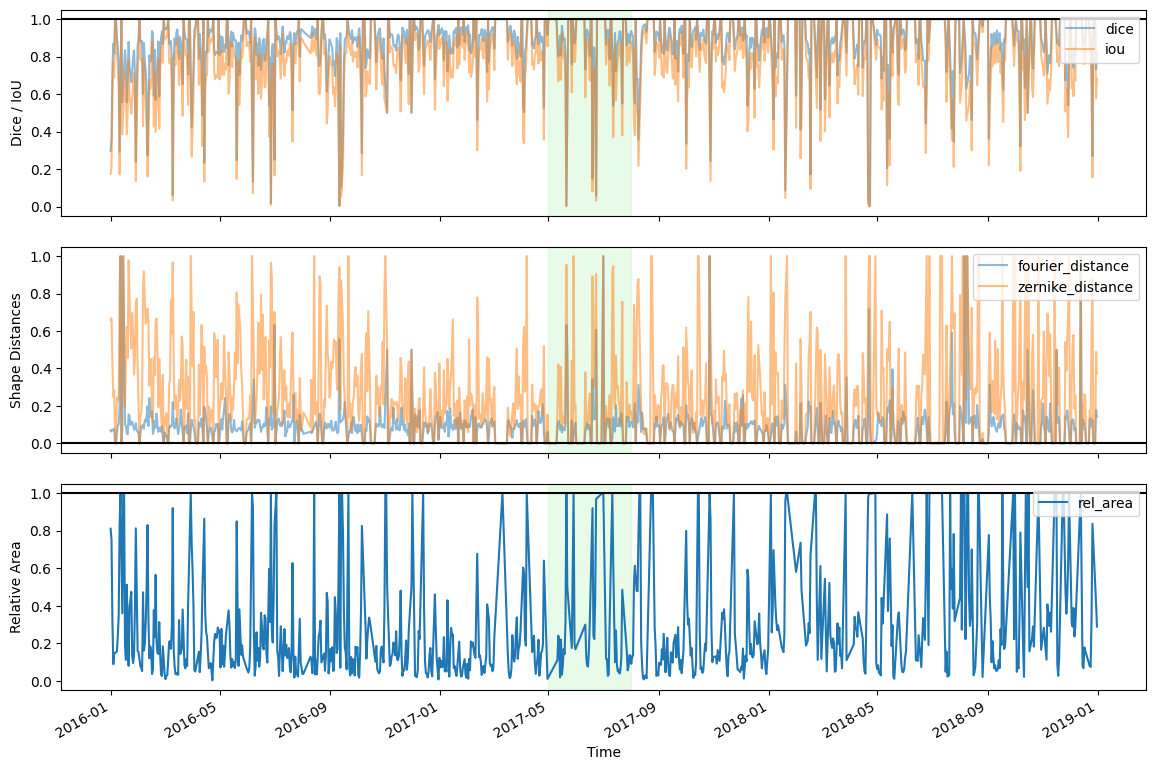

In [ ]:
# ---- 3. Determine which rows are in training set ----
train_idx = set(train_df.index.astype(str))
is_train = df.index.astype(str).isin(train_idx)

# ---- 4. Make the plot with 3 axes ----
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(14, 10), sharex=True, gridspec_kw={"hspace": 0.15}
)

times = stats_df.index

# ====================================================
# AXIS 1 — Dice / IoU (remove zeros)
# ====================================================
if "dice" in stats_df:
    dice_clean = stats_df["dice"].replace([0], pd.NA).dropna()
    ax1.plot(dice_clean.index, dice_clean, label="dice", alpha=0.5)

if "iou" in stats_df:
    iou_clean = stats_df["iou"].replace([0], pd.NA).dropna()
    ax1.plot(iou_clean.index, iou_clean, label="iou", alpha=0.5)

ax1.axhline(1, color="black")
ax1.set_ylabel("Dice / IoU")
ax1.legend(loc="upper right")

# ====================================================
# AXIS 2 — Fourier / Zernike distances (remove ones)
# ====================================================
if "fourier_distance" in stats_df:
    fd_clean = stats_df["fourier_distance"].replace([1], pd.NA).dropna()
    ax2.plot(fd_clean.index, fd_clean, label="fourier_distance", alpha=0.5)

if "zernike_distance" in stats_df:
    zd_clean = stats_df["zernike_distance"].replace([1], pd.NA).dropna()
    ax2.plot(zd_clean.index, zd_clean, label="zernike_distance", alpha=0.5)

ax2.axhline(0, color="black")
ax2.set_ylabel("Shape Distances")
ax2.legend(loc="upper right")

# ====================================================
# AXIS 3 — rel_area (remove NaN and zeros)
# ====================================================
if "rel_area" in stats_df:
    rel = np.abs(stats_df["rel_area"].replace([0], pd.NA).dropna())
    ax3.plot(rel.index, rel, label="rel_area")
    ax3.axhline(1, color="black")

ax3.set_ylabel("Relative Area")
ax3.set_xlabel("Time")
ax3.legend(loc="upper right")

# ====================================================
# 5. Shade training intervals
# ====================================================
axes = [ax1, ax2, ax3]
mask = is_train
t_array = df["time"].to_numpy()
n = len(mask)

for ax in axes:
    i = 0
    while i < n:
        if mask[i]:
            start = t_array[i]
            j = i
            while j + 1 < n and mask[j + 1]:
                j += 1
            end = t_array[j]
            ax.axvspan(start, end, color="lightgreen", alpha=0.2, zorder=-1)
            i = j + 1
        else:
            i += 1

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

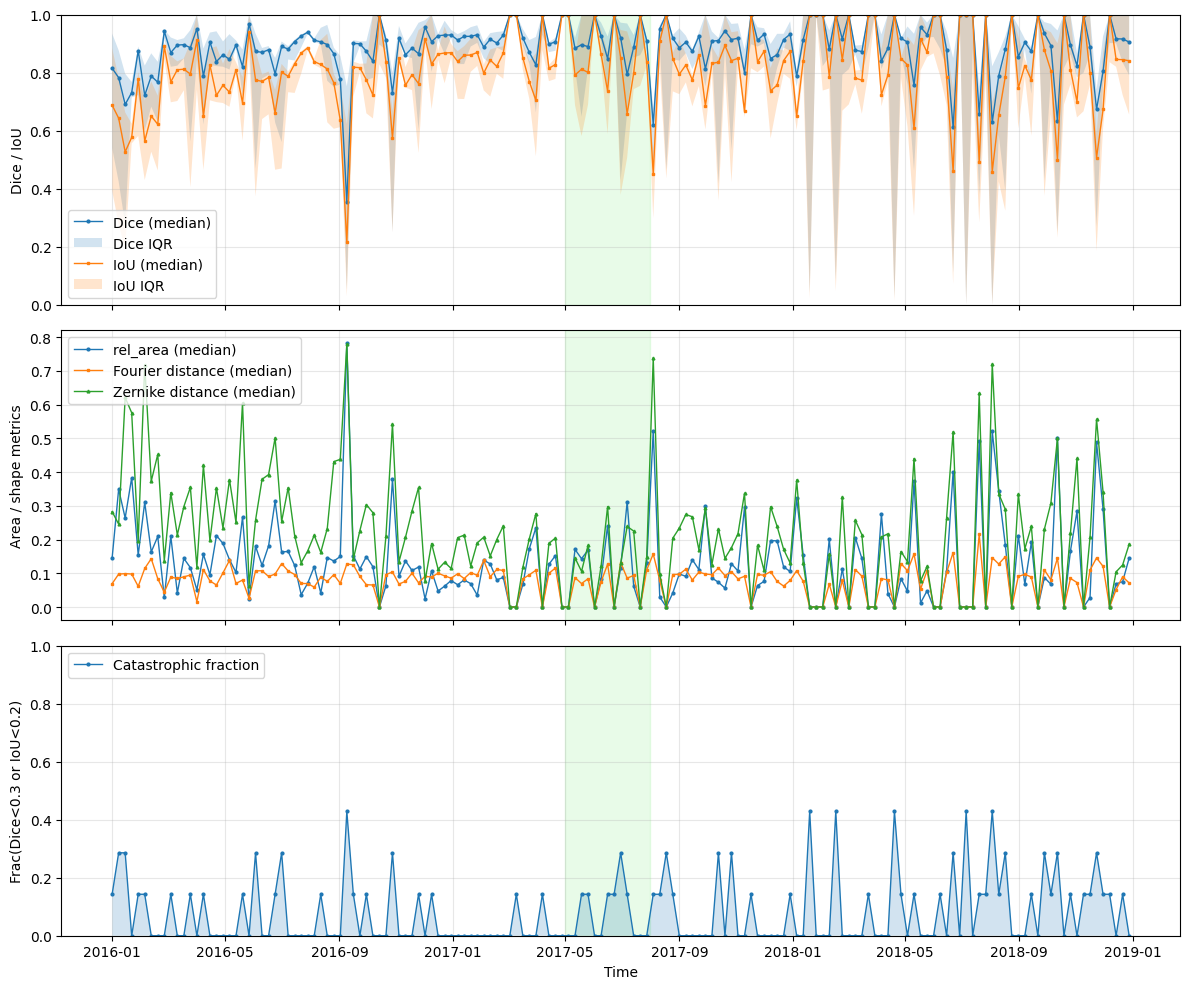

In [ ]:
# stats_df:
# DatetimeIndex, daily
# columns: ["fourier_distance", "zernike_distance", "rel_area", "iou", "dice"]
# some NaNs


# 1) Add a "catastrophic failure" flag per day
#    Definition: dice < 0.3 OR iou < 0.2 (you can tweak these)
def add_catastrophic_flag(stats_df, dice_thr=0.3, iou_thr=0.2):
    df = stats_df.copy()
    # work only where metrics are defined
    mask_valid = df[["dice", "iou"]].notna().all(axis=1)
    df["catastrophic"] = False
    df.loc[mask_valid, "catastrophic"] = (
        (df.loc[mask_valid, "dice"] < dice_thr)
        | (df.loc[mask_valid, "iou"] < iou_thr)
    )
    return df


stats_df_ext = add_catastrophic_flag(stats_df)


# 2) Build monthly summary:
#    - median, 25th, 75th percentiles of all metrics
#    - catastrophic fraction per month
def build_monthly_summary(stats_df_ext):
    """
    stats_df_ext: daily stats with columns
      fourier_distance, zernike_distance, rel_area, iou, dice, catastrophic
    index: DatetimeIndex (daily)
    """

    # We'll ignore days where a metric is NaN for its aggregation
    # (resample + agg will do that by default)
    monthly = stats_df_ext.resample("7d").agg(
        {
            "dice": ["median", lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
            "iou": ["median", lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
            "rel_area": [
                "median",
                lambda x: x.quantile(0.25),
                lambda x: x.quantile(0.75),
            ],
            "fourier_distance": [
                "median",
                lambda x: x.quantile(0.25),
                lambda x: x.quantile(0.75),
            ],
            "zernike_distance": [
                "median",
                lambda x: x.quantile(0.25),
                lambda x: x.quantile(0.75),
            ],
            "catastrophic": "mean",  # fraction of catastrophic days in month
        }
    )

    # Clean up column names
    monthly.columns = [
        "dice_median",
        "dice_q25",
        "dice_q75",
        "iou_median",
        "iou_q25",
        "iou_q75",
        "rel_area_median",
        "rel_area_q25",
        "rel_area_q75",
        "fourier_median",
        "fourier_q25",
        "fourier_q75",
        "zernike_median",
        "zernike_q25",
        "zernike_q75",
        "catastrophic_fraction",
    ]

    return monthly


monthly_stats = build_monthly_summary(stats_df_ext)


# 3) Plot monthly medians + IQR + catastrophe rate
def plot_monthly_summary(monthly_stats):
    """
    monthly_stats: output of build_monthly_summary()
    index: month-end DateTimeIndex
    """

    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    ax1, ax2, ax3 = axes

    # --- Panel 1: Dice & IoU (median + IQR) ---
    ax1.plot(
        monthly_stats.index,
        monthly_stats["dice_median"],
        label="Dice (median)",
        marker="o",
        linewidth=1,
    )
    ax1.fill_between(
        monthly_stats.index,
        monthly_stats["dice_q25"],
        monthly_stats["dice_q75"],
        alpha=0.2,
        label="Dice IQR",
    )

    ax1.plot(
        monthly_stats.index,
        monthly_stats["iou_median"],
        label="IoU (median)",
        marker="s",
        linewidth=1,
    )
    ax1.fill_between(
        monthly_stats.index,
        monthly_stats["iou_q25"],
        monthly_stats["iou_q75"],
        alpha=0.2,
        label="IoU IQR",
    )

    ax1.set_ylabel("Dice / IoU")
    ax1.set_ylim(0.0, 1.0)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc="lower left")

    # --- Panel 2: rel_area + shape distances (medians only) ---
    # If rel_area is signed, median near 0 is good; you can also plot abs(rel_area)
    ax2.plot(
        monthly_stats.index,
        monthly_stats["rel_area_median"],
        label="rel_area (median)",
        marker="o",
        linewidth=1,
    )

    ax2.plot(
        monthly_stats.index,
        monthly_stats["fourier_median"],
        label="Fourier distance (median)",
        marker="s",
        linewidth=1,
    )
    ax2.plot(
        monthly_stats.index,
        monthly_stats["zernike_median"],
        label="Zernike distance (median)",
        marker="^",
        linewidth=1,
    )

    ax2.set_ylabel("Area / shape metrics")
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc="upper left")

    # --- Panel 3: fraction of catastrophic frames per month ---
    ax3.plot(
        monthly_stats.index,
        monthly_stats["catastrophic_fraction"],
        label="Catastrophic fraction",
        marker="o",
        linewidth=1,
    )
    ax3.fill_between(
        monthly_stats.index,
        0,
        monthly_stats["catastrophic_fraction"],
        alpha=0.2,
    )

    ax3.set_ylabel("Frac(Dice<0.3 or IoU<0.2)")
    ax3.set_xlabel("Time")
    ax3.set_ylim(0.0, 1.0)
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc="upper left")

    axes = [ax1, ax2, ax3]
    mask = is_train
    t_array = df["time"].to_numpy()
    n = len(mask)

    for ax in axes:
        i = 0
        while i < n:
            if mask[i]:
                start = t_array[i]
                j = i
                while j + 1 < n and mask[j + 1]:
                    j += 1
                end = t_array[j]
                ax.axvspan(start, end, color="lightgreen", alpha=0.2, zorder=-1)
                i = j + 1
            else:
                i += 1


    plt.tight_layout()
    plt.show()


plot_monthly_summary(monthly_stats)